https://www.pymc-labs.com/blog-posts/markov-process/

In [2]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az

In [3]:
import datetime as dt

In [4]:
df = pd.read_csv("../Data/raw/president_polls.csv")
#df = pd.read_csv("../Data/raw/president_polls_historical.csv")

In [5]:
df['state'].fillna("National", inplace=True)

df['date'] = pd.to_datetime(df['end_date'])
df = df[df['date'] >= '2024-03-01']
df['week'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days // 7 + 200
df = df.set_index('date')

df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_67686/461211363.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['state'].fillna("National", inplace=True)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_67686/461211363.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['end_date'])


In [6]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

df = df.dropna()

In [7]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way["IND"] = 0
df_2way['OTH'] = 100 - (df_2way['DEM'] + df_2way['GOP'])
df_2way.loc[df_2way['OTH'] < 0, 'OTH'] = 0
df_2way['type'] = '2way'

In [8]:
df3 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden', 'Robert F. Kennedy'})

df_count = df3.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df3.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_3way = df_polls.merge(df_count)
df_3way = df_3way.rename(columns={'REP':'GOP'})
df_3way['OTH'] = 100 - (df_3way['DEM'] + df_3way['GOP'] + df_3way['IND'])
df_3way.loc[df_3way['OTH'] < 0, 'OTH'] = 0
df_3way['type'] = '3way'

In [9]:
df = pd.concat([df_2way, df_3way])
df['obs_id'] = range(len(df))
df = df.set_index('date')

# Define a function to map 'type' values to 'type_id'
def map_type_to_id(type_value):
    if type_value == '3way':
        return 1
    else:
        return 0

# Apply the function to create 'type_id' column
df['type_id'] = df['type'].apply(map_type_to_id)

In [10]:
df_2way[['DEM', 'GOP', 'OTH']].describe()

,DEM,GOP,OTH
count,519.000000,519.000000,519.000000
mean,44.387669,45.986513,9.625819
std,4.499923,4.763452,6.004016
min,25.000000,27.900000,0.000000
25%,42.150000,43.000000,6.000000
50%,44.000000,45.700000,10.000000
75%,47.000000,49.000000,13.000000
max,68.000000,60.600000,36.000000


In [11]:
df_3way[['DEM', 'GOP', 'IND', 'OTH']].describe()

,DEM,GOP,IND,OTH
count,102.000000,102.000000,102.000000,102.000000
mean,38.666667,41.663725,10.158824,9.511765
std,3.775464,4.313593,3.338357,5.569654
min,20.000000,27.000000,4.000000,0.000000
25%,37.000000,39.000000,7.425000,6.750000
50%,39.000000,42.000000,9.050000,9.800000
75%,41.000000,44.475000,13.000000,12.000000
max,48.000000,50.600000,20.000000,25.000000


In [12]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(10).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(10).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

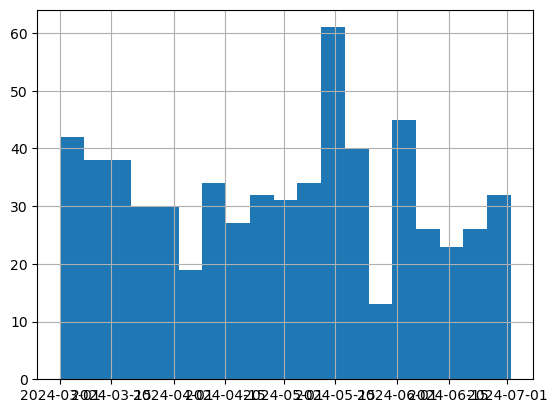

In [13]:
df.reset_index()["date"].hist(bins=len(df.week.unique()))
plt.show()

In [14]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone/Text-to-Web,Live Phone,Probability Panel,IVR/Text-to-Web,IVR/Online Panel,Online Panel/Text-to-Web,IVR/Online Panel/Text-to-Web,Live Phone/Online Panel/Text-to-Web,App Panel
pollster,,,,,,,,,,,
All,621,275,54,50,46,38,31,22,20,16,11
Morning Consult,148,148,0,0,0,0,0,0,0,0,0
Florida Atlantic University/Mainstreet Research,62,0,0,0,0,34,28,0,0,0,0
Emerson,34,0,0,0,0,0,3,1,19,0,0
Ipsos,30,0,0,0,30,0,0,0,0,0,0
YouGov,25,25,0,0,0,0,0,0,0,0,0
Siena/NYT,20,0,0,20,0,0,0,0,0,0,0
Big Data Poll,15,0,0,0,0,0,0,0,0,6,0
Benenson Strategy Group/GS Strategy Group,14,0,0,0,0,0,0,14,0,0,0


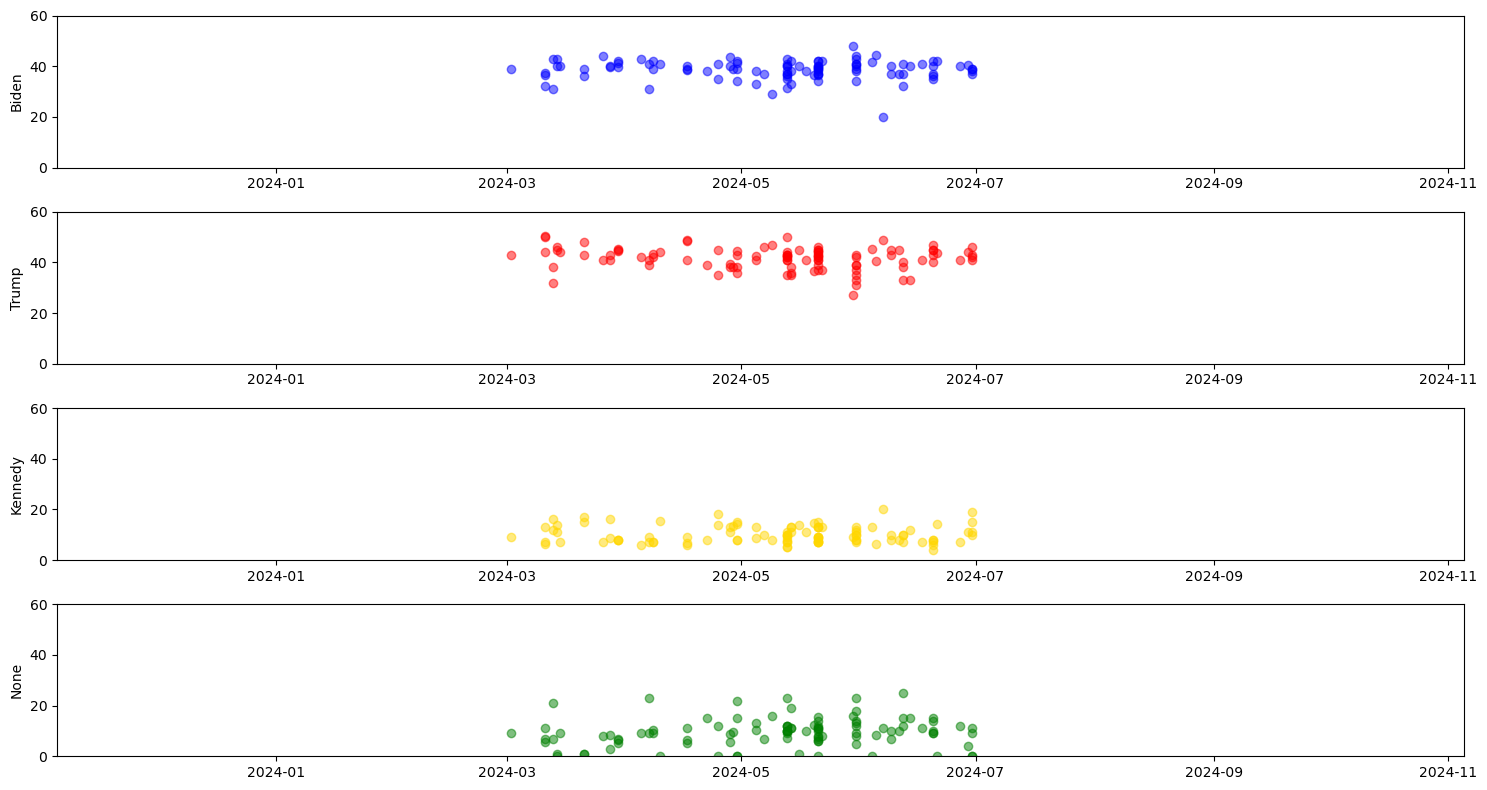

In [15]:
dem_votes = df_3way["DEM"].values
gop_votes = df_3way["GOP"].values
ind_votes = df_3way["IND"].values
oth_votes = df_3way["OTH"].values

dates = df_3way.set_index('date').index

fig, axes = plt.subplots(4, figsize=(15, 8))
for ax, rate, label, color in zip(
    axes.ravel(),
    [dem_votes, gop_votes, ind_votes, oth_votes],
    ["Biden", "Trump", "Kennedy", "None"],
    ['blue', 'red', 'gold', 'green']
):
    ax.plot(dates, rate, "o", alpha=0.5, color=color)
    ax.set_ylim(0, 60)
    ax.set_xlim(dt.datetime(2023, 11, 5), dt.datetime(2024, 11, 5))
    ax.set_ylabel(label)
    
plt.tight_layout()

plt.show()

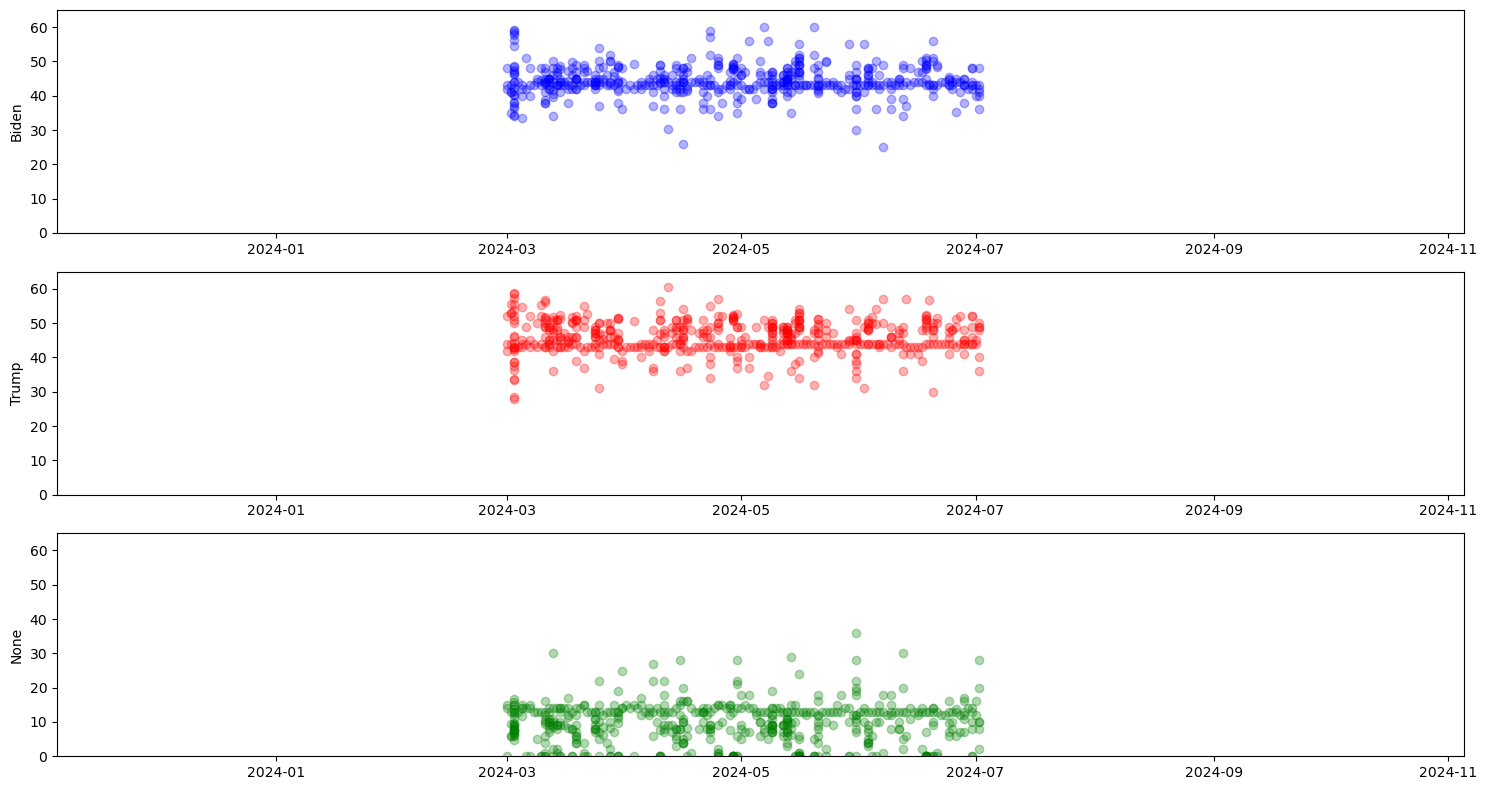

In [16]:
dem_votes = df_2way["DEM"].values
gop_votes = df_2way["GOP"].values
oth_votes = df_2way["OTH"].values

dates = df_2way.set_index('date').index

fig, axes = plt.subplots(3, figsize=(15, 8))
for ax, rate, label, color in zip(
    axes.ravel(),
    [dem_votes, gop_votes, oth_votes],
    ["Biden", "Trump", "None"],
    ['blue', 'red', 'green']
):
    ax.plot(dates, rate, "o", alpha=0.3, color=color)
    ax.set_ylim(0, 65)
    ax.set_xlim(dt.datetime(2023, 11, 5), dt.datetime(2024, 11, 5))
    ax.set_ylabel(label)
    
plt.tight_layout()

plt.show()

Text(0.5, 1.0, 'Monthly standard deviation in polls')

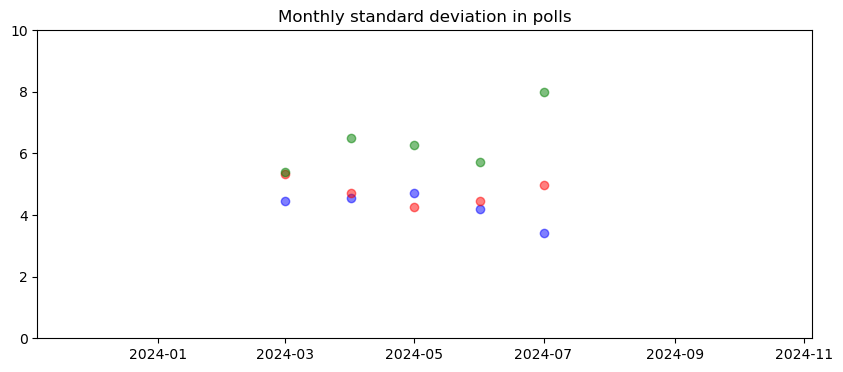

In [17]:
rolling_std = (
    df_2way[["year", "month", "DEM", "GOP", "OTH"]]
    .reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "DEM", "GOP", "OTH"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.DEM.values,
    "o",
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.GOP.values,
    "o",
    color = 'red',
    alpha=0.5,
)

ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.OTH.values,
    "o",
    color = 'green',
    alpha=0.5,
)

ax.set_ylim(0, 10)
ax.set_xlim(dt.datetime(2023, 11, 5), dt.datetime(2024, 11, 5))
ax.set_title("Monthly standard deviation in polls")

Text(0.5, 1.0, 'Monthly standard deviation in polls')

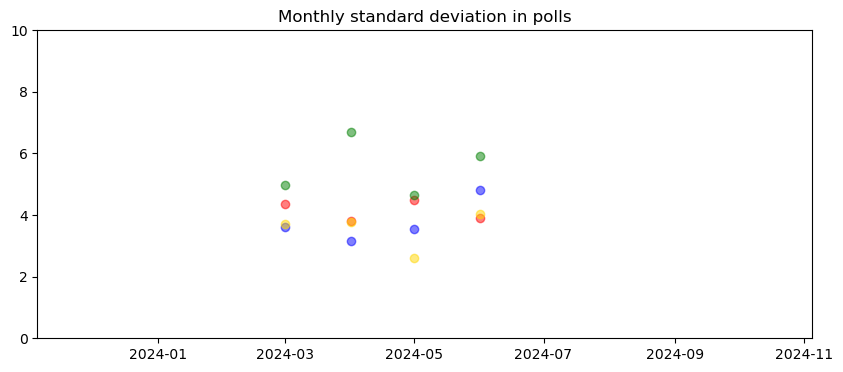

In [18]:
rolling_std = (
    df_3way[["year", "month", "DEM", "GOP", "IND", "OTH"]]
    .reset_index()
    .groupby(["year", "month"])
    .std()
    .reset_index()[["year", "month", "DEM", "GOP", "IND", "OTH"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.DEM.values,
    "o",
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.GOP.values,
    "o",
    color = 'red',
    alpha=0.5,
)
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.IND.values,
    "o",
    color = 'gold',
    alpha=0.5,
)
ax.plot(
    pd.to_datetime(
        [f"{y}-{m}-01" for y, m in zip(rolling_std.year, rolling_std.month)]
    ),
    rolling_std.OTH.values,
    "o",
    color = 'green',
    alpha=0.5,
)

ax.set_ylim(0, 10)
ax.set_xlim(dt.datetime(2023, 11, 5), dt.datetime(2024, 11, 5))
ax.set_title("Monthly standard deviation in polls")

We can see here that the polling methodology does not affect the Dem's mean performance however it drastically affects Trump, Kennedy, and other responses.

In [19]:
df.query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'App Panel']")[['methodology','DEM','GOP','IND','OTH']].groupby("methodology").mean()

,DEM,GOP,IND,OTH
methodology,,,,
App Panel,44.981818,48.663636,6.363636,0.000000
Live Phone,42.236000,46.906000,1.518000,9.340000
Online Panel,43.400727,44.735636,1.053091,10.810545
Probability Panel,42.500000,40.456522,2.652174,14.391304


We can see that Trump fairly consistently out-performs on Live Phone polls. These polls are rarer because they are more expensive however are often seen as higher quality.

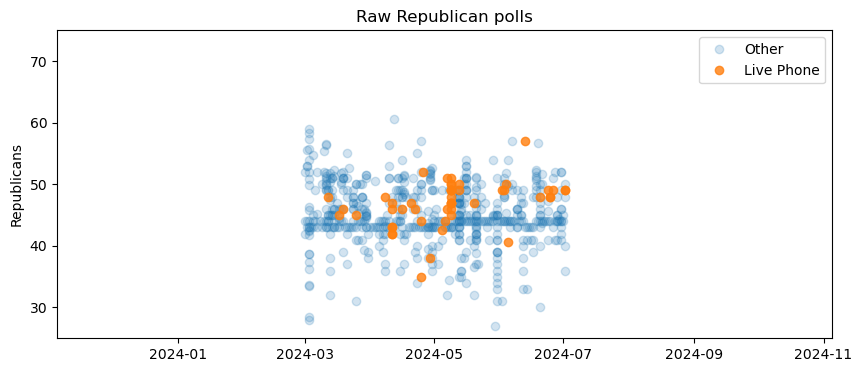

In [20]:
face = df[df["methodology"] == "Live Phone"]
dates_face = face.index

other = df[df["methodology"] != "Live Phone"]
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["GOP"].values, "o", alpha=0.2, label="Other")
ax.plot(dates_face, face["GOP"].values, "o", alpha=.8, label="Live Phone")
ax.set_ylim(0, 100)
ax.set_ylabel("Republicans")
ax.set_title("Raw Republican polls")

ax.set_ylim(25, 75)
ax.set_xlim(dt.datetime(2023, 11, 5), dt.datetime(2024, 11, 5))
ax.legend()

In [21]:
df["margin"] = df["DEM"]-df["GOP"]

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "IND", "OTH", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [22]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]
df["diff_IND"] = df["IND"] - df["IND_mean"]
df["diff_OTH"] = df["OTH"] - df["OTH_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,GOP_mean,DEM_mean,IND_mean,OTH_mean,margin_mean,diff_GOP,diff_DEM,diff_IND,diff_OTH,diff_margin
0,2024-07-02,87297,201890,241,Ipsos,Probability Panel,National,rv,892.0,2024,...,45.33,41.67,0.00,13.0,-3.67,-5.33,-1.67,0.00,7.0,3.67
1,2024-07-02,87297,202061,241,Ipsos,Probability Panel,National,a,1070.0,2024,...,45.33,41.67,0.00,13.0,-3.67,-9.33,-5.67,0.00,15.0,3.67
2,2024-07-02,87303,202024,1822,Fabrizio/GBAO,Live Phone/Text-to-Web,National,rv,1500.0,2024,...,45.33,41.67,0.00,13.0,-3.67,2.67,0.33,0.00,-3.0,-2.33
3,2024-07-02,87299,201938,568,YouGov,Online Panel,National,lv,2815.0,2024,...,45.33,41.67,0.00,13.0,-3.67,4.67,6.33,0.00,-11.0,1.67
4,2024-07-02,87302,202014,1424,Siena/NYT,Live Phone,National,rv,1532.0,2024,...,45.33,41.67,0.00,13.0,-3.67,3.67,-0.67,0.00,-3.0,-4.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,2024-03-13,86471,194763,241,Ipsos,Probability Panel,National,a,4094.0,2024,...,41.00,39.40,12.00,7.6,-1.60,-9.00,-8.40,4.00,13.4,0.60
617,2024-03-11,86922,198835,1873,Big Data Poll,Live Phone/Online Panel/Text-to-Web/Text,Florida,rv,1378.0,2024,...,48.17,35.20,8.83,7.8,-12.97,1.73,1.20,-1.83,-1.1,-0.53
618,2024-03-11,86922,198836,1873,Big Data Poll,Live Phone/Online Panel/Text-to-Web/Text,Florida,lv,1318.0,2024,...,48.17,35.20,8.83,7.8,-12.97,2.43,2.00,-2.33,-2.1,-0.43
619,2024-03-11,86469,194648,460,SurveyUSA,Online Panel,Ohio,rv,1241.0,2024,...,48.17,35.20,8.83,7.8,-12.97,-4.17,-3.20,4.17,3.2,0.97


Trump has a much greater lead in a three-way race:

In [23]:
df.groupby('type')[['margin']].mean()

,margin
type,
2way,-1.598844
3way,-2.997059


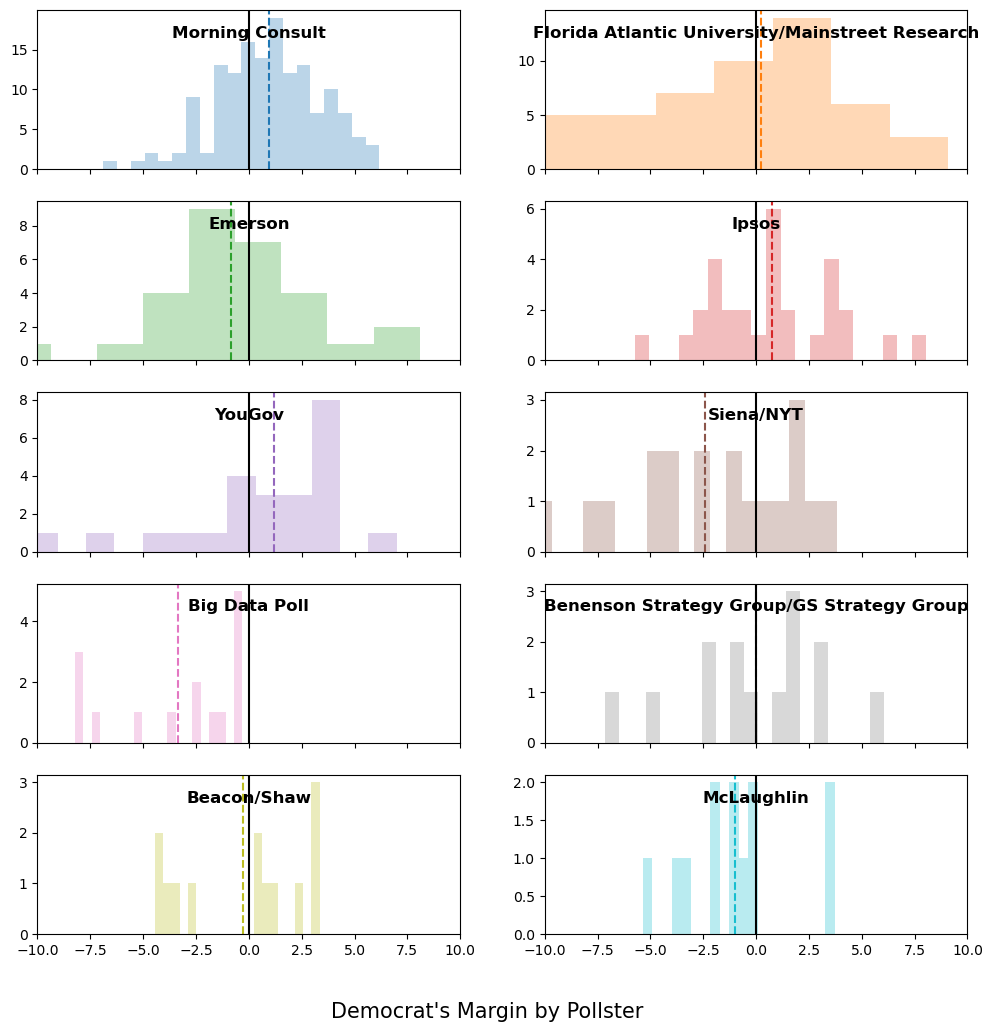

In [24]:
POLLSTER_VALS = {
    pollster: df[df["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-10, 10)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

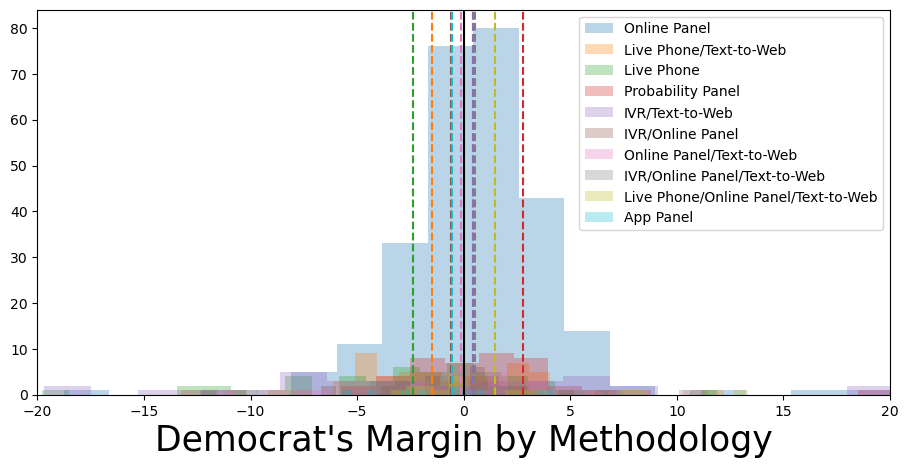

In [25]:
METHOD_VALS = {
    method: df[df["methodology"] == method]["diff_margin"].values
    for method in METHODS_top
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method, bins=25)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-20, 20)
ax.set_xlabel(r"Democrat's Margin by Methodology", fontsize=25)
ax.legend();

In [26]:
df

,date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,GOP_mean,DEM_mean,IND_mean,OTH_mean,margin_mean,diff_GOP,diff_DEM,diff_IND,diff_OTH,diff_margin
0,2024-07-02,87297,201890,241,Ipsos,Probability Panel,National,rv,892.0,2024,...,45.333333,41.666667,0.000000,13.0,-3.666667,-5.333333,-1.666667,0.000000,7.0,3.666667
1,2024-07-02,87297,202061,241,Ipsos,Probability Panel,National,a,1070.0,2024,...,45.333333,41.666667,0.000000,13.0,-3.666667,-9.333333,-5.666667,0.000000,15.0,3.666667
2,2024-07-02,87303,202024,1822,Fabrizio/GBAO,Live Phone/Text-to-Web,National,rv,1500.0,2024,...,45.333333,41.666667,0.000000,13.0,-3.666667,2.666667,0.333333,0.000000,-3.0,-2.333333
3,2024-07-02,87299,201938,568,YouGov,Online Panel,National,lv,2815.0,2024,...,45.333333,41.666667,0.000000,13.0,-3.666667,4.666667,6.333333,0.000000,-11.0,1.666667
4,2024-07-02,87302,202014,1424,Siena/NYT,Live Phone,National,rv,1532.0,2024,...,45.333333,41.666667,0.000000,13.0,-3.666667,3.666667,-0.666667,0.000000,-3.0,-4.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,2024-03-13,86471,194763,241,Ipsos,Probability Panel,National,a,4094.0,2024,...,41.000000,39.400000,12.000000,7.6,-1.600000,-9.000000,-8.400000,4.000000,13.4,0.600000
617,2024-03-11,86922,198835,1873,Big Data Poll,Live Phone/Online Panel/Text-to-Web/Text,Florida,rv,1378.0,2024,...,48.166667,35.200000,8.833333,7.8,-12.966667,1.733333,1.200000,-1.833333,-1.1,-0.533333
618,2024-03-11,86922,198836,1873,Big Data Poll,Live Phone/Online Panel/Text-to-Web/Text,Florida,lv,1318.0,2024,...,48.166667,35.200000,8.833333,7.8,-12.966667,2.433333,2.000000,-2.333333,-2.1,-0.433333
619,2024-03-11,86469,194648,460,SurveyUSA,Online Panel,Ohio,rv,1241.0,2024,...,48.166667,35.200000,8.833333,7.8,-12.966667,-4.166667,-3.200000,4.166667,3.2,0.966667


In [41]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

In [121]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "population": population,
    "week": week,
    "observation": df.obs_id
}

In [126]:
with pm.Model(coords=COORDS) as pooled_popularity_simple:

    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.1, dims="pollster")
    dem_method_effect = pm.Normal("dem_method_effect", 0, 0.1, dims="method")
    dem_state_effect = pm.Normal("dem_state_effect", 0, 0.1, dims="state")
    dem_pop_effect = pm.Normal("dem_pop_effect", 0, 0.1, dims="population")
    dem_week_effect = pm.GaussianRandomWalk("dem_week_effect", sigma=0.1, init_dist=pm.Normal.dist(mu=0, sigma=0.1), dims="week")
    dem_3way = pm.Normal("dem_3way", 0, 0.1)

    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.1, dims="pollster")
    gop_method_effect = pm.Normal("gop_method_effect", 0, 0.1, dims="method")
    gop_state_effect = pm.Normal("gop_state_effect", 0, 0.1, dims="state")
    gop_pop_effect = pm.Normal("gop_pop_effect", 0, 0.1, dims="population")
    gop_week_effect = pm.GaussianRandomWalk("gop_week_effect", sigma=0.1, init_dist=pm.Normal.dist(mu=0, sigma=0.1), dims="week")
    gop_3way = pm.Normal("gop_3way", 0, 0.1)

    ind_pollster_effect = pm.Normal("ind_pollster_effect", 0, 0.1, dims="pollster")
    ind_method_effect = pm.Normal("ind_method_effect", 0, 0.1, dims="method")
    ind_state_effect = pm.Normal("ind_state_effect", 0, 0.1, dims="state")
    ind_pop_effect = pm.Normal("ind_pop_effect", 0, 0.1, dims="population")
    ind_week_effect = pm.GaussianRandomWalk("ind_week_effect", sigma=.1, init_dist=pm.Normal.dist(mu=0, sigma=0.1), dims="week")

    oth_pollster_effect = pm.Normal("oth_pollster_effect", 0, 0.1, dims="pollster")
    oth_method_effect = pm.Normal("oth_method_effect", 0, 0.1, dims="method")
    oth_state_effect = pm.Normal("oth_state_effect", 0, 0.1, dims="state")
    oth_pop_effect = pm.Normal("oth_pop_effect", 0, 0.1, dims="population")
    oth_week_effect = pm.GaussianRandomWalk("oth_week_effect", sigma=.1, init_dist=pm.Normal.dist(mu=0, sigma=0.1), dims="week")
    oth_3way = pm.Normal("oth_3way", 0, 0.1)

    type_race = pm.Data("type_race", df['type_id'])

    dem_polling = (1 + dem_3way * type_race) * pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_state_effect[state_id] +
        dem_pop_effect[population_id] +
        dem_week_effect[week_id]
    )

    gop_polling = (1 + gop_3way * type_race) * pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_state_effect[state_id] +
        gop_pop_effect[population_id] +
        gop_week_effect[week_id]
    )

    ind_polling = type_race * pm.math.invlogit(
        ind_pollster_effect[pollster_id] +
        ind_method_effect[method_id] +
        ind_state_effect[state_id] +
        ind_pop_effect[population_id] +
        ind_week_effect[week_id]
    )

    oth_polling = (1 + oth_3way * type_race) * pm.math.invlogit(
        oth_pollster_effect[pollster_id] +
        oth_method_effect[method_id] +
        oth_state_effect[state_id] +
        oth_pop_effect[population_id] +
        oth_week_effect[week_id]
    )

    dem_vote = pm.Binomial(
        "dem_vote",
        p=dem_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['DEM'] / 100,
        dims="observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p=gop_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['GOP'] / 100,
        dims="observation",
    )

    ind_vote = pm.Binomial(
        "ind_vote",
        p=ind_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['IND'] / 100,
        dims="observation",
    )

    oth_vote = pm.Binomial(
        "oth_vote",
        p=oth_polling,
        n=df["sample_size"],
        observed=df['sample_size'] * df['OTH'] / 100,
        dims="observation",
    )

    idata = pm.sample(draws=100, cores=14, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (14 chains in 14 jobs)
NUTS: [dem_pollster_effect, dem_method_effect, dem_state_effect, dem_pop_effect, dem_week_effect, dem_3way, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_pop_effect, gop_week_effect, gop_3way, ind_pollster_effect, ind_method_effect, ind_state_effect, ind_pop_effect, ind_week_effect, oth_pollster_effect, oth_method_effect, oth_state_effect, oth_pop_effect, oth_week_effect, oth_3way]
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pytensor/compile/function/types.py:1138: UserWarning: aliased relationship between Function arguments 19, 19 will not be preserved by un-pickling operation
  warnings.warn(


Output()

Sampling 14 chains for 1_000 tune and 100 draw iterations (14_000 + 1_400 draws total) took 426 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [127]:
# Sample posterior predictive for out-of-sample predictions
posterior_predictive = pm.sample_posterior_predictive(idata, model=pooled_popularity_simple).assign_coords(COORDS)

Sampling: [dem_vote, gop_vote, ind_vote, oth_vote]


Output()

In [128]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

<xarray.DataArray 'gop_method_effect' (chain: 14, draw: 100)> Size: 11kB
array([[-0.02071083,  0.01786398,  0.03976626, ..., -0.0452423 ,
        -0.03232292, -0.01693653],
       [ 0.00729733,  0.00538797,  0.00367812, ..., -0.04988513,
        -0.06631693, -0.02696554],
       [-0.05054971, -0.05187961, -0.02378034, ..., -0.0790871 ,
         0.02726215, -0.00603283],
       ...,
       [-0.04038992, -0.02384292, -0.01606631, ..., -0.09157655,
        -0.0377041 , -0.04011231],
       [ 0.02399783,  0.0595787 ,  0.0003587 , ...,  0.02215666,
         0.00861994,  0.01145608],
       [-0.05454027, -0.0624777 , -0.0070534 , ..., -0.09989835,
        -0.08975461, -0.03074631]])
Coordinates:
  * chain    (chain) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * draw     (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99

In [142]:
idata.posterior.sel(method = 'App Panel')

<xarray.Dataset> Size: 8MB
Dimensions:              (chain: 14, draw: 100, method: 29, pollster: 86,
                          population: 4, state: 39, week: 19)
Coordinates:
  * chain                (chain) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * draw                 (draw) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * method               (method) <U40 5kB 'App Panel' ... 'Text-to-Web/Onlin...
  * pollster             (pollster) <U47 16kB 'ActiVote' ... 'co/efficient'
  * population           (population) <U2 32B 'a' 'lv' 'rv' 'v'
  * state                (state) <U14 2kB 'Alabama' 'Alaska' ... 'Wisconsin'
  * week                 (week) int64 152B 164 165 166 167 ... 179 180 181 182
Data variables: (12/23)
    dem_3way             (chain, draw) float64 11kB -0.1228 -0.117 ... -0.1236
    dem_method_effect    (chain, draw, method) float64 325kB -0.02465 ... -0....
    dem_pollster_effect  (chain, draw, pollster) float64 963kB 0.07089 ... -0...
    dem_pop_effect       (chain, draw, population) float64 45kB -0.2396 ... 0...
    dem_state_effect     (chain, draw, state) float64 437kB -0.2782 ... 0.1111
    dem_week_effect      (chain, draw, week) float64 213kB -0.3067 ... -0.241
    ...                   ...
    oth_3way             (chain, draw) float64 11kB -0.07616 -0.09061 ... -0.095
    oth_method_effect    (chain, draw, method) float64 325kB -1.046 ... 0.498
    oth_pollster_effect  (chain, draw, pollster) float64 963kB -1.137 ... 0.3801
    oth_pop_effect       (chain, draw, population) float64 45kB 0.3086 ... -0...
    oth_state_effect     (chain, draw, state) float64 437kB 0.07849 ... -0.4503
    oth_week_effect      (chain, draw, week) float64 213kB -1.571 ... -1.675
Attributes:
    created_at:                 2024-07-07T15:21:17.259103+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.1
    sampling_time:              425.70849609375
    tuning_steps:               1000

In [200]:
d_fl = pd.DataFrame()

d_fl['DEM'] = ((1 + idata.posterior.dem_3way) * inv_logit(idata.posterior.dem_pollster_effect.mean(axis=2) +
idata.posterior['dem_method_effect'].where(idata.posterior['dem_method_effect'].method == 'Live Phone', drop=True).mean(axis=2) +
idata.posterior.dem_state_effect.mean(axis=0).sel(state="National") +
idata.posterior.dem_pop_effect.mean(axis=0).sel(population="lv") + #Likely votes
idata.posterior.dem_week_effect.mean(axis=0).sel(week=164))).values.ravel() #current week

d_fl['GOP'] = ((1 + idata.posterior.gop_3way) * inv_logit(idata.posterior.gop_pollster_effect.mean(axis=2) +
idata.posterior['gop_method_effect'].where(idata.posterior['gop_method_effect'].method == 'Live Phone', drop=True).mean(axis=2) +
idata.posterior.gop_state_effect.mean(axis=0).sel(state="National") +
idata.posterior.gop_pop_effect.mean(axis=0).sel(population="lv") + #Likely votes
idata.posterior.gop_week_effect.mean(axis=0).sel(week=164))).values.ravel() #current week

d_fl['IND'] = (inv_logit(idata.posterior.ind_pollster_effect.mean(axis=2) +
idata.posterior['ind_method_effect'].where(idata.posterior['ind_method_effect'].method == 'Live Phone', drop=True).mean(axis=2) +
idata.posterior.ind_state_effect.mean(axis=0).sel(state="National") +
idata.posterior.ind_pop_effect.mean(axis=0).sel(population="lv") + #Likely votes
idata.posterior.ind_week_effect.mean(axis=0).sel(week=164))).values.ravel() #current week

In [201]:
d_fl['Margin'] = d_fl['DEM'] - d_fl['GOP']

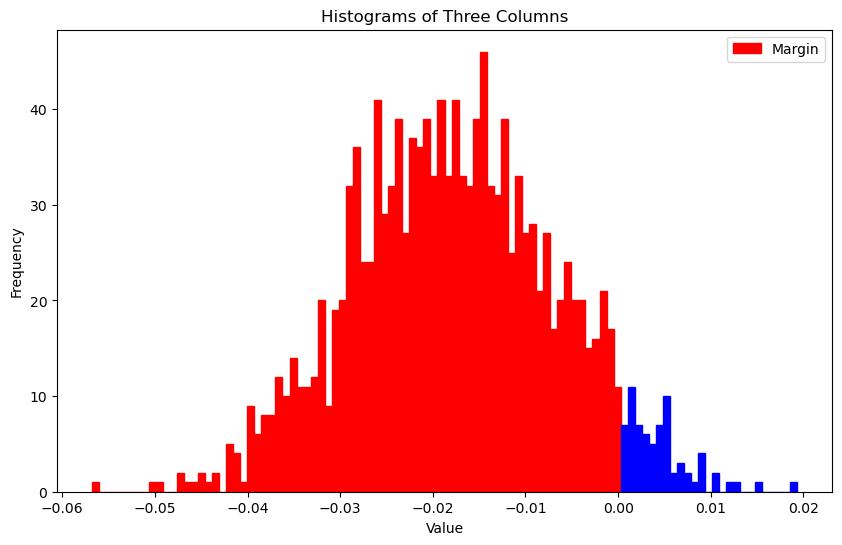

In [202]:
# Plotting the histograms
plt.figure(figsize=(10, 6))

ax = d_fl['Margin'].plot.hist(bins = 100)

for bar in ax.containers[0]:
    # get x midpoint of bar
    x = bar.get_x() + 0.5 * bar.get_width()

    # set bar color based on x
    if x < 0:
        bar.set_color('red')
    elif x > 0:
        bar.set_color('blue')
    else:
        bar.set_color('green')

# Adding titles and labels
plt.title('Histograms of Three Columns')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Display the plot
plt.show()


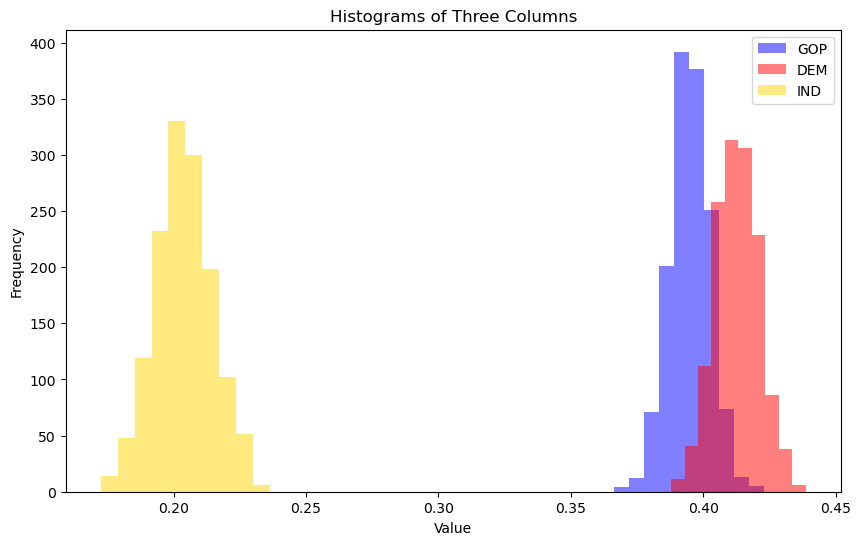

In [203]:
# Plotting the histograms
plt.figure(figsize=(10, 6))

plt.hist(d_fl['DEM'], bins=10, alpha=0.5, color='blue', label='GOP')
plt.hist(d_fl['GOP'], bins=10, alpha=0.5, color='red', label='DEM')
plt.hist(d_fl['IND'], bins=10, alpha=0.5, color='gold', label='IND')

# Adding titles and labels
plt.title('Histograms of Three Columns')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Display the plot
plt.show()


In [130]:
(1 + idata.posterior.dem_3way.mean(axis=0)) * inv_logit(idata.posterior.dem_pollster_effect.mean(axis=0).mean(axis=1) +
idata.posterior.dem_method_effect.mean(axis=0).sel(method="Live Phone") +
idata.posterior.dem_state_effect.mean(axis=0).sel(state="Florida") +
idata.posterior.dem_pop_effect.mean(axis=0).sel(population="lv") + #Likely votes
idata.posterior.dem_week_effect.mean(axis=0).sel(week=182)) #current week

<xarray.DataArray (draw: 100, method: 29)> Size: 23kB
array([[0.38391137, 0.38466209, 0.38841917, ..., 0.34822578, 0.37761449,
        0.35919662],
       [0.39476187, 0.39527155, 0.38649019, ..., 0.35021558, 0.38501886,
        0.36530545],
       [0.38115485, 0.38250448, 0.38651577, ..., 0.34057968, 0.38124943,
        0.35379059],
       ...,
       [0.38692066, 0.38458154, 0.38349318, ..., 0.35248784, 0.37515584,
        0.36971722],
       [0.38995394, 0.38755215, 0.38809967, ..., 0.3575932 , 0.3766973 ,
        0.36004829],
       [0.39024211, 0.3858959 , 0.38695279, ..., 0.35207908, 0.37754308,
        0.36184502]])
Coordinates:
  * draw        (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * method      (method) <U40 5kB 'App Panel' ... 'Text-to-Web/Online Ad'
    state       <U14 56B 'Florida'
    population  <U2 8B 'lv'
    week        int64 8B 182

In [67]:
idata.posterior.gop_pollster_effect.mean(axis=0).mean(axis=1)

<xarray.DataArray 'gop_pollster_effect' (draw: 100)> Size: 800B
array([-8.86845051e-04, -2.25634559e-03, -2.44997224e-03, -4.50042028e-04,
        1.79450888e-03,  1.72655461e-03, -6.12095560e-05,  2.42933848e-03,
       -6.23330568e-04,  4.45284731e-03,  3.38063878e-03,  9.77415622e-04,
        3.25525344e-03,  6.52912642e-04,  4.55550295e-03,  4.42633564e-03,
        9.10902403e-03,  1.65904798e-03, -2.58453492e-03,  2.71830304e-03,
        4.55547639e-04,  4.79009007e-03,  7.38955529e-04, -1.17073380e-03,
        4.03533738e-03,  2.11624666e-03, -2.65214754e-04,  4.19883471e-03,
        2.07789046e-03, -2.57330179e-03,  1.45328969e-03,  1.01139809e-03,
        3.96394345e-03,  6.73765957e-03,  2.34277029e-03,  4.93962033e-03,
       -1.04720727e-03,  1.46633416e-03,  6.47246456e-04,  1.16717317e-03,
       -1.83273060e-03, -1.86125361e-03,  7.24298250e-04, -1.26160071e-03,
        2.22992085e-03,  3.39295804e-03,  1.50359776e-03,  4.01177198e-03,
       -3.53385974e-03,  7.78053926e-04,  2.41021839e-03, -9.23005537e-04,
       -3.61036739e-03, -1.89373408e-03,  1.92940222e-03, -2.27356617e-03,
       -2.26169705e-03, -3.01141050e-03, -2.69987446e-03, -2.85469064e-03,
        8.87324975e-04,  1.41187235e-03, -3.65588324e-03, -1.35421198e-04,
        4.32305388e-03, -1.24345979e-03,  2.20717729e-03, -5.23040807e-04,
       -2.63614644e-04, -5.99288406e-04, -4.44248410e-04, -3.74586565e-04,
        1.65821951e-03,  1.30525600e-03,  1.62617378e-03,  1.88461558e-03,
        2.36764619e-03,  3.79758957e-03, -1.85273663e-03, -2.57769588e-03,
       -2.38907911e-04,  1.78872114e-03,  2.68244220e-05, -1.53073126e-03,
       -1.69241658e-04, -2.37617725e-03, -2.34148892e-04, -1.84784509e-03,
       -2.92793367e-04, -1.46279894e-03,  2.52055420e-03,  2.23963617e-03,
        3.65746858e-03,  2.13904409e-03,  5.89819962e-03,  5.36061698e-03,
       -2.50018562e-03,  5.25673354e-03,  3.86265323e-04, -1.19303039e-03])
Coordinates:
  * draw     (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99

In [74]:
df_x = pd.DataFrame()

df_x['gop_fl'] = np.ravel(
    (1 + idata.posterior.gop_3way) * inv_logit(
    idata.posterior.gop_method_effect.sel(method="Live Phone") +
    idata.posterior.gop_state_effect.sel(state="Florida") +
    idata.posterior.gop_pop_effect.sel(population="lv") + #Likely votes
    idata.posterior.gop_week_effect.sel(week=182).mean(axis=1)) #current week
)

In [117]:
idata.posterior.gop_method_effect.sel(method = "Mail-to-Web/Mail-to-Phone")

<xarray.DataArray 'gop_method_effect' (chain: 14, draw: 100, method: 29)> Size: 325kB
array([[[ 1.15890989e-01,  5.19282752e-02,  1.77134167e-02, ...,
         -1.69235356e-01, -5.58819234e-02, -1.98835478e-01],
        [-5.60035278e-03, -2.12832464e-02, -6.37975129e-02, ...,
         -2.13215230e-01,  7.07591728e-02, -5.06350469e-02],
        [ 1.22278711e-01,  2.41879661e-01,  1.11977487e-01, ...,
         -1.46173284e-01,  1.44570299e-03, -1.21038110e-01],
        ...,
        [ 1.50611821e-01, -8.54437463e-02, -6.05475414e-03, ...,
         -2.97400121e-02, -1.50830735e-02,  2.22446418e-04],
        [ 5.42495135e-02,  3.75409502e-02,  1.89370146e-01, ...,
         -8.66345280e-02, -5.22870907e-02, -1.36077187e-01],
        [ 8.92362040e-02, -8.26742884e-02, -1.00517493e-01, ...,
         -2.25464605e-01, -4.51149081e-03, -1.43210263e-01]],

       [[-2.23488077e-02, -4.79817516e-02, -4.37421173e-02, ...,
         -8.14039238e-02,  8.40194052e-03, -7.88977324e-02],
        [-1.21752320e-01,  2.93928527e-02, -9.77109483e-02, ...,
         -1.87535219e-01, -2.21008987e-02, -1.38013859e-01],
        [ 2.80947291e-01,  1.81499176e-01,  2.63715436e-03, ...,
         -8.79195812e-02,  1.81241390e-02, -7.61295339e-02],
...
        [ 1.09285269e-01,  8.06325044e-02,  2.40350769e-02, ...,
         -1.63025686e-01, -1.37054621e-01, -1.08658228e-01],
        [ 1.13168817e-01,  1.05374853e-01,  1.12235652e-01, ...,
         -9.91883911e-02, -5.32181637e-02, -1.95395813e-01],
        [ 1.01290015e-01, -7.46251456e-02,  9.25985770e-03, ...,
         -1.80724633e-01,  8.87762076e-03, -1.32350183e-01]],

       [[ 1.90851203e-02,  9.11858461e-02,  2.29995611e-03, ...,
         -5.05967612e-02, -1.21153788e-01, -4.60952289e-02],
        [ 3.70236693e-02, -2.11526357e-02,  7.49755101e-02, ...,
         -1.68451820e-01, -9.89048403e-02, -1.01096344e-01],
        [ 1.97342614e-01,  3.42715757e-02, -2.65930784e-02, ...,
         -1.39524452e-01,  7.82683569e-02,  6.43533074e-03],
        ...,
        [ 7.40404534e-02, -2.57029680e-02, -7.57112715e-03, ...,
         -1.73226288e-01, -1.16115192e-01, -4.69995316e-02],
        [ 7.99399832e-02,  7.52045503e-02, -2.29840869e-02, ...,
         -1.12653447e-01,  4.04787042e-02, -2.30269937e-01],
        [ 8.15678372e-02, -2.33189320e-02, -1.47358439e-03, ...,
         -1.98583049e-01,  5.22141646e-02, -6.65360661e-02]]])
Coordinates:
  * chain    (chain) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * draw     (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * method   (method) <U40 5kB 'App Panel' ... 'Text-to-Web/Online Ad'

In [83]:
(
    (1 + idata.posterior.gop_3way) * inv_logit(
    idata.posterior.gop_method_effect.sel(method="Live Phone") +
    idata.posterior.gop_state_effect.sel(state="Florida") +
    idata.posterior.gop_pop_effect.sel(population="lv") + #Likely votes
    idata.posterior.gop_week_effect.sel(week=182).mean(axis=1)) #current week
)

<xarray.DataArray (chain: 14, draw: 100, method: 29, week: 6)> Size: 2MB
array([[[[0.53463971, 0.53412594, 0.53118768, 0.53138419, 0.53098884,
          0.52957815],
         [0.52097537, 0.52045532, 0.5174819 , 0.51768072, 0.51728073,
          0.51585365],
         [0.51360129, 0.51307828, 0.51008832, 0.51028822, 0.50988605,
          0.5084513 ],
         ...,
         [0.47271014, 0.47217608, 0.46912523, 0.46932909, 0.46891899,
          0.46745653],
         [0.49760932, 0.49708091, 0.4940609 , 0.49426277, 0.49385666,
          0.49240808],
         [0.46617092, 0.46563594, 0.4625802 , 0.46278436, 0.46237365,
          0.46090908]],

        [[0.51925471, 0.51873148, 0.51574005, 0.51594007, 0.51553768,
          0.51410208],
         [0.51585944, 0.51533488, 0.51233599, 0.51253649, 0.51213312,
          0.51069407],
         [0.50661365, 0.50608576, 0.50306837, 0.50327009, 0.50286428,
          0.50141669],
...
         [0.4963794 , 0.49843413, 0.49574484, 0.49974082, 0.4943142 ,
          0.49249702],
         [0.52978951, 0.53179711, 0.52916922, 0.53307311, 0.52777026,
          0.52599235],
         [0.47030728, 0.47238261, 0.46966658, 0.473703  , 0.4682225 ,
          0.46638904]],

        [[0.51786715, 0.51985152, 0.51725407, 0.52111284, 0.51587144,
          0.51411439],
         [0.49533875, 0.49735547, 0.49471587, 0.49863785, 0.49331147,
          0.49152744],
         [0.50005953, 0.50207036, 0.49943843, 0.50334889, 0.49803797,
          0.4962588 ],
         ...,
         [0.45708516, 0.45913221, 0.45645325, 0.46043474, 0.45502907,
          0.45322107],
         [0.51159936, 0.51359381, 0.51098322, 0.51486167, 0.50959378,
          0.50782826],
         [0.48596216, 0.48798918, 0.48533618, 0.48927832, 0.48392493,
          0.48213248]]]])
Coordinates:
  * chain       (chain) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * draw        (draw) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * method      (method) <U40 5kB 'App Panel' ... 'Text-to-Web/Online Ad'
    state       <U14 56B 'Florida'
    population  <U2 8B 'lv'
  * week        (week) int64 48B 182 182 182 182 182 182

array([[<Axes: title={'center': 'gop_fl'}>]], dtype=object)

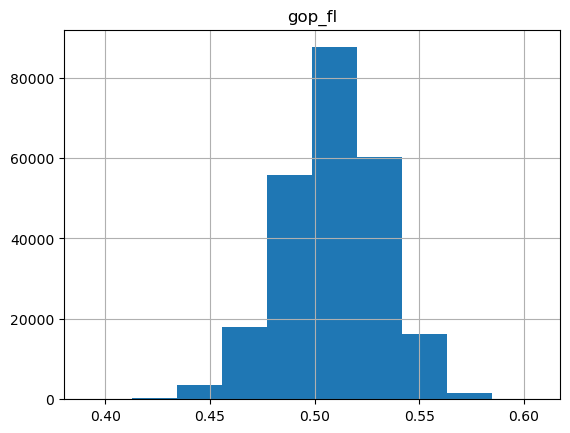

In [76]:
df_x.hist()

In [ ]:
az.plot_trace(idata);

In [ ]:
idata.posterior

In [ ]:
dem_polling = (1 + idata.posterior.dem_3way.mean(axis=0)) * pm.math.invlogit(
        idata.posterior.dem_pollster_effect.mean(axis=0).mean(axis=1) +
        idata.posterior.dem_method_effect.mean(axis=0).mean(axis=1) +
#        dem_state_effect[state_id] +
        idata.posterior.dem_pop_effect.mean(axis=0).mean(axis=1) +
        idata.posterior.dem_week_effect.mean(axis=0).sel(week=182)
    )

In [ ]:
dem_week_effect_max_week = idata.posterior.dem_week_effect.sel(week=max_week)

NameError: name 'idata' is not defined

In [1200]:
idata.posterior.dem_week_effect.mean(axis=0).mean(axis=0).values

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [1202]:
df_post = pd.DataFrame()
df_post['mean_dem'] = idata.posterior['dem_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_gop'] = idata.posterior['gop_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_ind'] = idata.posterior['ind_state_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_oth'] = idata.posterior['oth_state_effect'].mean(axis=0).mean(axis=0).values
df_post['state'] = idata.posterior['dem_state_effect'].state.values

df_post.groupby('state').mean()

,mean_dem,mean_gop,mean_ind,mean_oth
state,,,,
Alabama,-0.163199,0.190793,0.003338,-0.076458
Alaska,-0.166906,0.131427,-0.000617,0.025629
Arizona,0.015740,0.060961,0.012451,-0.203281
California,0.333699,-0.386126,-0.001987,0.203238
Colorado,0.090240,-0.098460,0.000256,0.011548
Florida,-0.062933,0.187263,-0.183604,-0.232996
Georgia,-0.004307,0.098121,0.078279,-0.328820
Hawaii,0.161800,-0.158408,0.001836,-0.040258
Indiana,-0.196588,0.119837,0.000547,0.353494


In [932]:
idata.posterior['dem_state_effect'].state.values

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maine CD-1', 'Maine CD-2', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nebraska CD-2', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype='<U14')

<Axes: xlabel='president'>

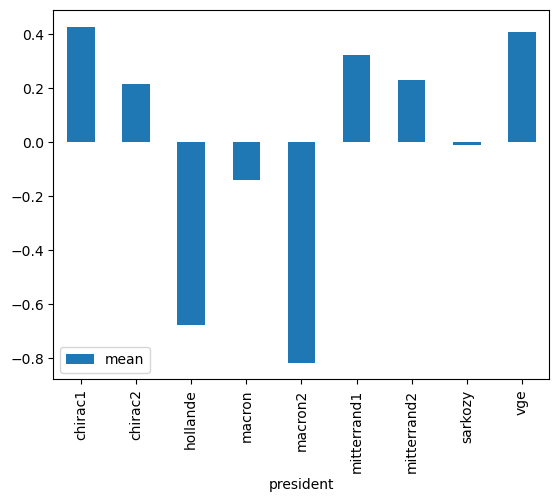

In [19]:
df = pd.DataFrame()

df = pd.DataFrame()
df['mean'] = idata.posterior['president_effect'].mean(axis=0).mean(axis=0).values
df['president'] = idata.posterior['president_effect'].president.values

df.groupby('president').mean().plot(kind="bar")

<Axes: xlabel='week'>

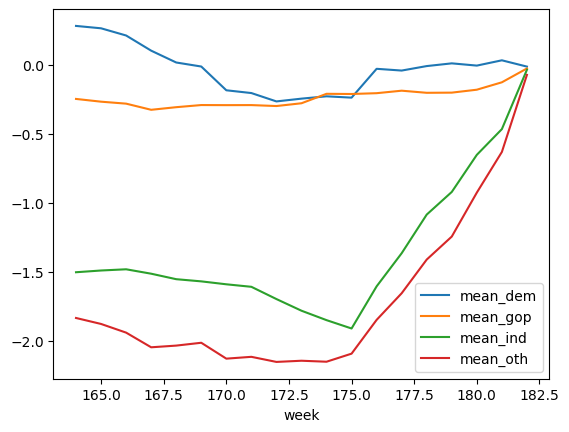

In [1207]:
df_post = pd.DataFrame()
df_post['mean_dem'] = idata.posterior['dem_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_gop'] = idata.posterior['gop_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_ind'] = idata.posterior['ind_week_effect'].mean(axis=0).mean(axis=0).values
df_post['mean_oth'] = idata.posterior['oth_week_effect'].mean(axis=0).mean(axis=0).values
df_post['week'] = idata.posterior.week.values

df_post.groupby('week').mean().plot()

In [960]:
def plot_latent_mu(inference_data, overlay_observed=True):
    """Plot latent posterior popularity"""
    post_pop = logistic(
        inference_data.posterior["dem_week_effect"].stack(sample=("chain", "draw"))
    )

    fig, ax = plt.subplots()

    # plot random posterior draws
    ax.plot(
        inference_data.posterior.coords["week"],
        post_pop.isel(
            sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )

    # plot posterior mean
    post_pop.mean("sample").plot(ax=ax, color="black", lw=2, label="predicted mean")

    ax.set_xlabel("Months into term")
    ax.set_ylabel("Does approve")
    ax.legend()

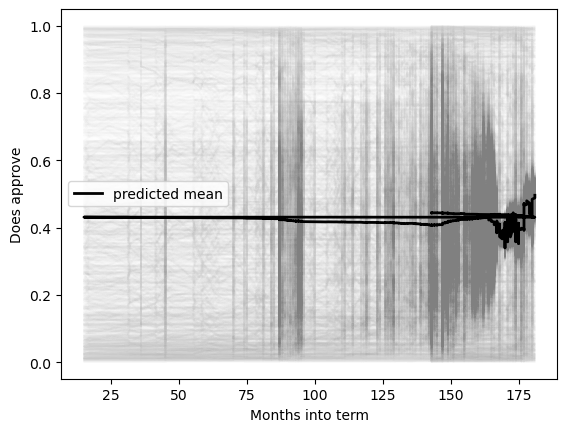

In [961]:
plot_latent_mu(idata)

In [23]:
from typing import *


def ZeroSumNormal(
    name: str,
    sigma: float = 1.0,
    *,
    dims: Union[str, Tuple[str]],
    model: Optional[pm.Model] = None,
):
    """
    Multivariate normal, such that sum(x, axis=-1) = 0.

    Parameters

    name: str
        String name representation of the PyMC variable.
    sigma: float, defaults to 1
        Scale for the Normal distribution. If none is provided, a standard Normal is used.
    dims: Union[str, Tuple[str]]
        Dimension names for the shape of the distribution.
        See https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html for an example.
    model: Optional[pm.Model], defaults to None
        PyMC model instance. If ``None``, a model instance is created.

    Notes
-   ----------
    Contributed by Adrian Seyboldt (@aseyboldt).
    """
    if isinstance(dims, str):
        dims = (dims,)

    model = pm.modelcontext(model)
    *dims_pre, dim = dims
    dim_trunc = f"{dim}_truncated_"
    (shape,) = model.shape_from_dims((dim,))
    assert shape >= 1

    model.add_coords({f"{dim}_truncated_": pd.RangeIndex(shape - 1)})
    raw = pm.Normal(
        f"{name}_truncated_", dims=tuple(dims_pre) + (dim_trunc,), sigma=sigma
    )
    Q = make_sum_zero_hh(shape)
    draws = aet.dot(raw, Q[:, 1:].T)

    return pm.Deterministic(name, draws, dims=dims)


def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)

COORDS["month_minus_origin"] = COORDS["month"][1:]

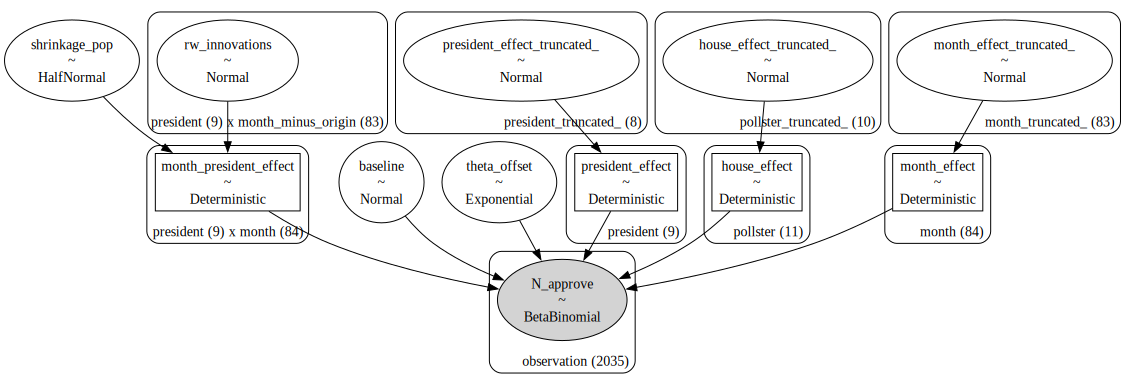

In [24]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    baseline = pm.Normal("baseline")
    president_effect = ZeroSumNormal("president_effect", sigma=0.15, dims="president")
    house_effect = ZeroSumNormal("house_effect", sigma=0.15, dims="pollster")
    month_effect = ZeroSumNormal("month_effect", sigma=0.15, dims="month")

    # need the cumsum parametrization to properly control the init of the GRW
    rw_init = aet.zeros(shape=(len(COORDS["president"]), 1))
    rw_innovations = pm.Normal(
        "rw_innovations",
        dims=("president", "month_minus_origin"),
    )
    raw_rw = aet.cumsum(aet.concatenate([rw_init, rw_innovations], axis=-1), axis=-1)
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.Deterministic(
        "month_president_effect", raw_rw * sd, dims=("president", "month")
    )

    popularity = pm.math.invlogit(
        baseline
        + president_effect[president_id]
        + month_effect[month_id]
        + month_president_effect[president_id, month_id]
        + house_effect[pollster_id]
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    N_approve = pm.BetaBinomial(
        "N_approve",
        alpha=popularity * theta,
        beta=(1.0 - popularity) * theta,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )
pm.model_to_graphviz(hierarchical_popularity)

In [25]:
with hierarchical_popularity:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, president_effect_truncated_, house_effect_truncated_, month_effect_truncated_, rw_innovations, shrinkage_pop, theta_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 267 seconds.


/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


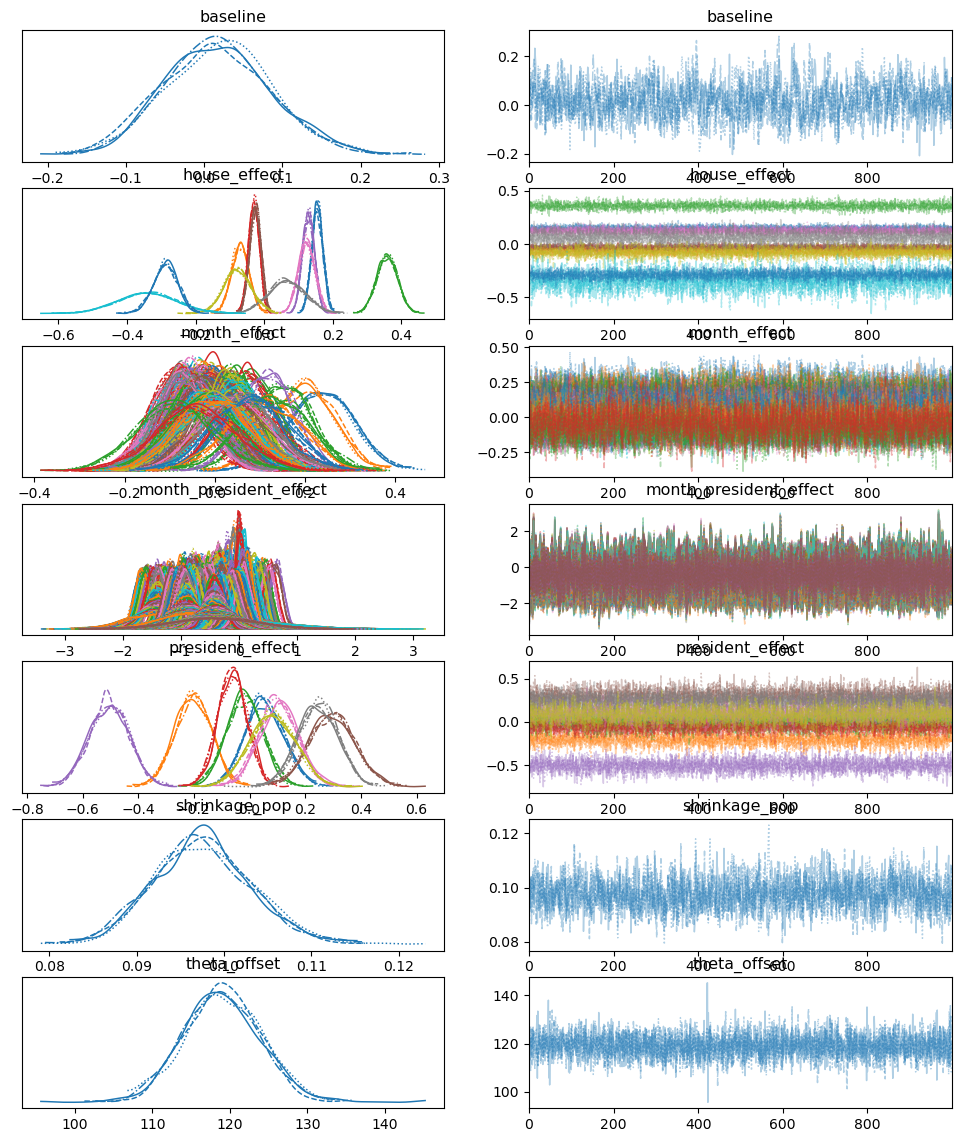

In [26]:
arviz.plot_trace(
    idata,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
    compact=True,
);

In [27]:
arviz.summary(
    idata,
    round_to=2,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
)

/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (n

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,0.02,0.07,-0.11,0.15,0.00,0.00,894.76,1653.80,1.0
house_effect[BVA],0.16,0.02,0.13,0.19,0.00,0.00,2700.10,2782.97,1.0
house_effect[Elabe],-0.07,0.03,-0.12,-0.02,0.00,0.00,4202.10,3294.66,1.0
house_effect[Harris],0.36,0.03,0.30,0.41,0.00,0.00,4574.67,3096.85,1.0
house_effect[Ifop],-0.03,0.02,-0.06,-0.00,0.00,0.00,2039.60,2604.14,1.0
...,...,...,...,...,...,...,...,...,...
president_effect[mitterrand2],0.10,0.07,-0.03,0.23,0.00,0.00,3553.36,2782.25,1.0
president_effect[sarkozy],0.25,0.07,0.12,0.38,0.00,0.00,3302.49,2867.73,1.0
president_effect[vge],0.08,0.08,-0.07,0.23,0.00,0.00,3841.99,3203.38,1.0
shrinkage_pop,0.10,0.01,0.09,0.11,0.00,0.00,1359.82,2468.22,1.0


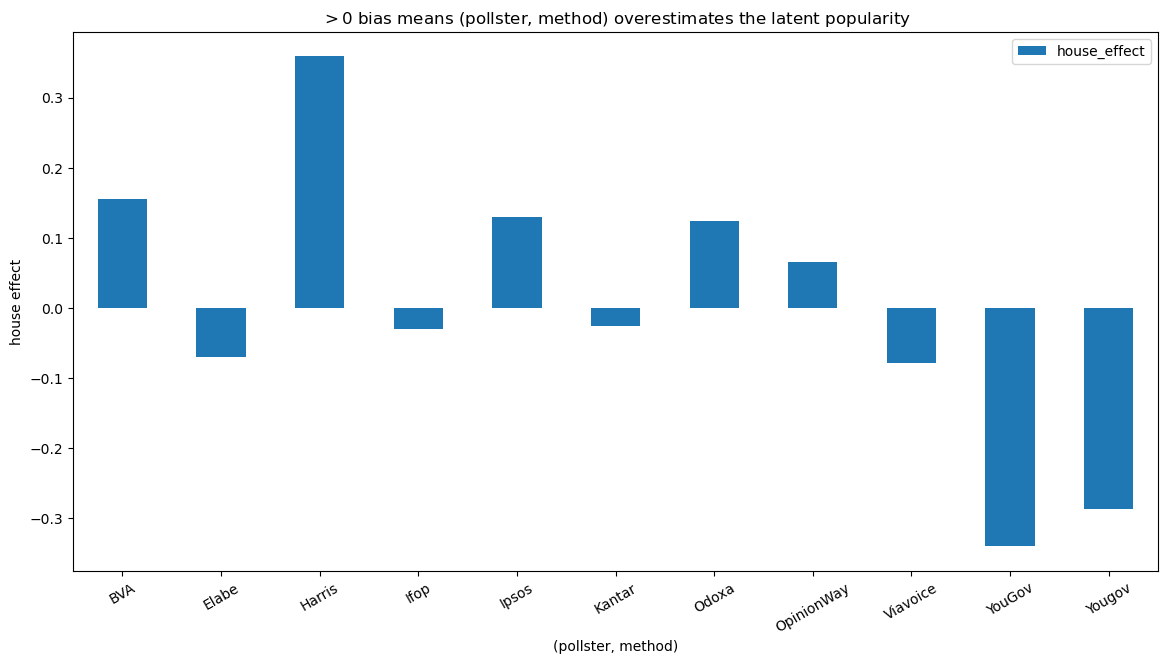

In [28]:
mean_house_effect = (
    idata.posterior["house_effect"].mean(("chain", "draw")).to_dataframe()
)
ax = mean_house_effect.plot.bar(figsize=(14, 7), rot=30)
ax.set_xlabel("(pollster, method)")
ax.set_ylabel("house effect")
ax.set_title("$>0$ bias means (pollster, method) overestimates the latent popularity");


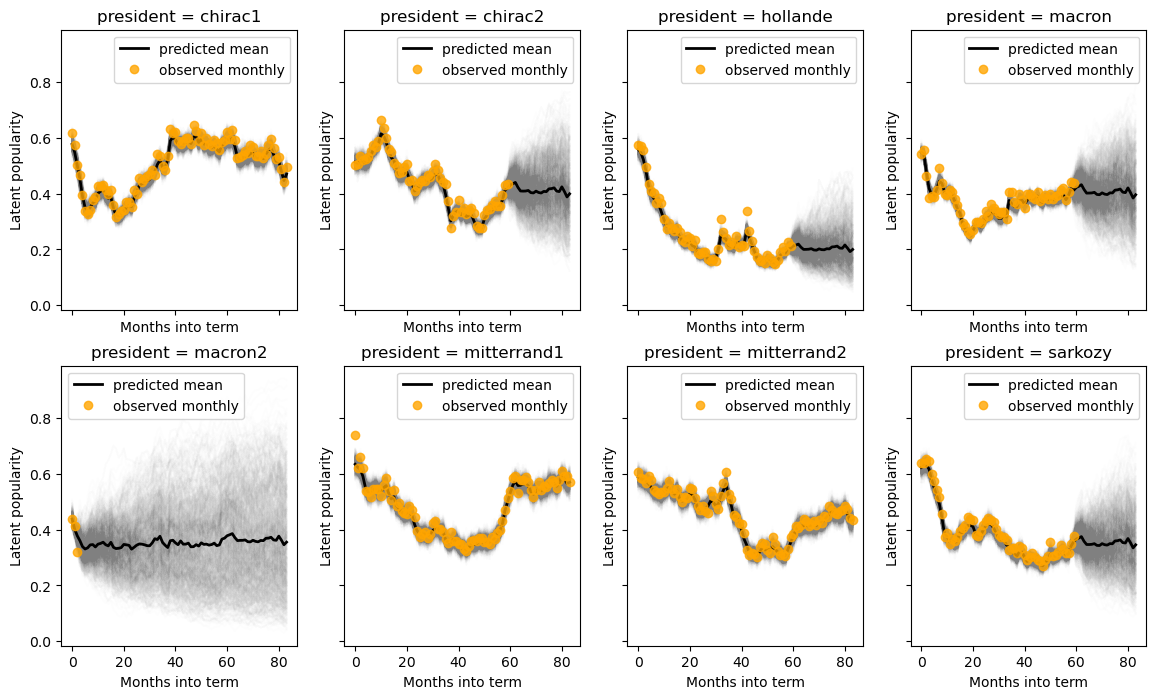

In [29]:
obs_mean = (data.groupby(["president", "month_id"]).last()["approve_pr_mean"]/100).unstack().T

fig, axes = plt.subplots(2, 4, figsize=(14, 8), sharex=True, sharey=True)

for ax, p in zip(axes.ravel(), idata.posterior.coords["president"]):
    post = idata.posterior.sel(president=p)
    post_pop = logistic(
        (
            post["baseline"]
            + post["president_effect"]
            + post["month_effect"]
            + post["month_president_effect"]
        ).stack(sample=("chain", "draw"))
    )
    # plot random posterior draws
    ax.plot(
        post.coords["month"],
        post_pop.isel(
            sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )
    # plot posterior mean
    post_pop.mean("sample").plot(ax=ax, color="black", lw=2, label="predicted mean")
    # plot monthly raw polls
    ax.plot(
        obs_mean.index,
        obs_mean[p.data],
        "o",
        color="orange",
        alpha=0.8,
        label="observed monthly",
    )
    ax.set_xlabel("Months into term")
    ax.set_ylabel("Latent popularity")
    ax.legend()